# Thema 13: Ausbreitung einer ansteckenden Krankheit

#### Mathematische Software - Olaf Bochmann - WiSe 2022/23

#### Kilian Runnwerth (577371), Dominic Lehm (573590)

## 1. Einführung

Seit nun fast drei Jahren verfolgen wir hautnah die Ausbreitung einer ansteckenden Krankheit, SARS-CoV-2, welche uns in allen Bereichen des alltäglichen Lebens beeinflusst. Kontaktbeschränkungen und Maskenpflicht sind nur einige der von der Bundesregierung verhängten Maßnahmen zur Einschränkung der Krankheitsausbreitung. Zuletzt immer wieder heiß diskutiert wurde außerdem eine branchenabhängige Impfplicht.  
Bei der Bekämpfung des Virus spielen Computersimulationen eine elementare Rolle; sowohl bei der Impfstoffentwicklung und Symptombehandlung, als auch für die Prognose der Ausbreitung der Krankheit.
&nbsp;

In diesem Projekt wird nun die Ausbreitung einer Krankheit mit gegebener Ansteckungswahrscheinlichkeit in einer kontrollierten Umgebung, einem Schlafsaal, mittels Python3 simuliert bzw. prognostiziert. Hierbei wird auch auf Sonderfälle eingegangen, bspw. die Existenz eines Impfstoffes, und deren Einfluss auf die Ausbreitung der Krankheit betrachtet.  
Der Code basiert auf einer $nxm$-Matrix, wobei jeder Eintrag eine Person im Schlafsaal symbolisiert. Im Folgenden wird diese Matrix deshalb als Schlafsaal-Matrix bezeichnet. An gegebener Stelle wird diese zeilenweise in einen Vektor umgeformt; um Verwechslungen auszuschließen wird dieser als Personen-Vektor bezeichnet. Je nach aktuellem Gesundheitszustand der Person erhält der entsprechende Eintrag der Schlafsaal-Matrix einen der folgenden Werte:

| **Gesundheitszustand der Person** |   **Wert**       |
|:------------------------------------:|:----------------:|
| tot                                  |      -2     |
| gesund, nicht ansteckbar             |      -1     |
| gesund, aber ansteckbar              |      0      |
| heute angesteckt                     |     0.5     |
| erkrankt, in der Inkubationszeit     |   1 bis i       |
| erkrankt, nach der Inkubationszeit   | i+1 bis i+k        |

**Beispiel:** Eine Person, die die Inkubationszeit $i=3$ überstanden hat und sich nun im dritten Tag der Krankheitsdauer befindet, erhält in der Schlafsaal-Matrix den Wert $i+3=3+3=6$.
&nbsp;

Zu Beginn des Beobachtungszeitraums infiziert sich eine Person im Schlafsaal mit der ansteckenden Krankheit, hier und im Folgenden wird diese als Patient 0 bezeichnet. Alle weiteren Personen im Schlafsaal sind gesund, aber ansteckbar. Patient 0 wird nun am Folgetag mit Ansteckungswahrscheinlichkeit $p$ seine direkten Nachbarn infizieren. Diese infizieren im Falle einer Ansteckung mit Ansteckungswahrscheinlichkeit $p$ auch ihre Nachbarn, usw. Die Krankheit breitet sich aus. Nach $i+k$ Tagen hat die infizierte Person die Krankheit überstanden und gilt nun als immun (gesund, nicht ansteckbar).
&nbsp;

Tageweise wird ein Bild des aktuellen Standes der Krankheitsausbreitung erzeugt. Als Ergebnis des Projektes werden diese Bilder animiert und ausgegeben.

## 2. Code
### 2.1 Importieren der genutzen Pakete und Funktionen
Zunächst werden alle benötigten Pakete und Funktionen importiert. Diese sind bereits aus der Vorlesung bekannt.

In [1]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
plt.rcParams['figure.figsize'] = [10, 7]  # larger figures
from matplotlib.ticker import LinearLocator
import matplotlib.animation as animation
from IPython.display import HTML
from matplotlib.animation import FuncAnimation

### 2.2 Setzen des Seed (optional)
Zwecks Replizierbarkeit ist es sinnvoll, einen Seed zu definieren, sodass in jedem Durchlauf des Projektes dieselben Zufallszahlen generiert werden. So können die Einflussstärken der einzelnen Parameter beobachtet und verglichen werden.

In [2]:
random.seed(123) # anstelle der 123 kann jede beliebige reele Zahl eingegeben werden # Quelle: [1] https://www.w3schools.com/python/ref_random_seed.asp

### 2.3 Instanziieren der Variablen
Die Userin kann frei über die Umstände der Krankheitsausbreitung entscheiden. Hierzu werden im Folgenden sowohl die essenziellen, als auch die Variablen der optionalen Sonderfälle instanziiert. Dies geschieht mithilfe mehrerer ``input()``-Funktionen.  
Des Weiteren kann die Userin auswählen, ob die Animation als Bilderstrecke oder als Video ausgegeben bzw. gespeichert wird.

In [3]:
# Essenzielle Variablen
n = int(input("Wieviele Zeilen soll der Schlafsaal besitzen? "))
m = int(input("Wieviele Spalten soll der Schlafsaal besitzen? "))
k_x = int(input("In welcher Zeile liegt Patient 0? ")) - 1 # abzüglich 1, da in Python die Indexmenge bei 0 beginnt
k_y = int(input("In welcher Spalte liegt Patient 0? ")) - 1 # abzüglich 1, da in Python die Indexmenge bei 0 beginnt
p = float(input("Bitte geben Sie die Ansteckungswahrscheinlichkeit in Prozent an: ")) /100 # geteilt durch 100, Dezimaldarstellung
k = int(input("Bitte geben Sie die Krankheitsdauer (abzüglich der Inkubationszeit) in Tagen an: "))

# Sonderfall A: Es besteht das Risiko, dass eine erkrankte Person stirbt.
# Verstorbene Person werden am Folgetag durch eine gesunde, aber ansteckbare Person ersetzt.
frage_t = int(input("Besitzt die Krankheit eine Todeswahrscheinlichkeit (1-ja, 0-nein)? ")) 
if frage_t == 1:
    t = float(input("Bitte geben Sie die tagesbezogene Todeswahrscheinlichkeit in Prozent an: ")) /100 # geteilt durch 100, Dezimaldarstellung
    
# Sonderfall B: Die Krankheit besitzt eine Inkubationszeit, in der die Person zwar krank, aber noch nicht ansteckend ist.
i = 0 # Die Inkubationszeit wird standarmäßig auf 0 Tage gesetzt, kann aber von der Userin verändert werden.
frage_i = int(input("Besitzt die Krankheit eine Inkubationszeit (1-ja, 0-nein)? "))
if frage_i == 1:
    i = int(input("Bitte geben Sie die Inkubationszeit in Tagen an: "))

# Sonderfall C: Es existiert ein Impfstoff. 
# Geimpfte Personen sind gesund und nicht ansteckbar.
# Nur gesunde, aber ansteckbare Personen werden geimpft.
frage_impf = int(input("Sollen Impfungen vorgenommen werden (1-ja, 0-nein)? "))
if frage_impf == 1:
    impf_start = int(input("Bitte geben Sie an, an welchem Tag die Impfungen starten sollen: ")) # Da Impfstoffe nicht immer ab Tag 0 verfügbar sind, kann dies durch die Userin hinausgezögert werden.
    impf_zahl = int(input("Bitte geben Sie die Anzahl der täglich zu impfenden Personen an an: ")) # Die Userin kann die verfügbare Menge des Impfstoffes anpassen.

# Sonderfall D: Jeden Tag wechselt eine bestimmte Anzahl an zufällig ausgewählten Personen das Bett.
wechsel = 0
frage_wechsel = int(input("Sollen Personen das Bett wechseln (1-ja, 0-nein)? "))
if frage_wechsel == 1:
    wechsel = int(input("Wieviele Personen wechseln jeden Tag das Bett? "))
    
# Art der Animation
video_animation = int(input("Soll die Animation als Video gespeichert (Eingabe: 0) oder nur ausgegeben (Eingabe: 1) oder tageweise als Bilderstrecke ausgegeben (Eingabe: 2) werden? "))

### 2.4 Instanziieren der Variablen zur Betrachtung von Einflussstärken (optional)
Im Folgenden kann die Userin die Variablen instanziieren, ohne die Fragen im Einzelnen beantworten zu müssen. Dies ist besonders nützlich für die Betrachtung von Einflussstärken der Parameter, wenn nur einzelne Variablenwerte geändert werden sollen.  
Dieser Code-Abschnitt ist standardmäßig auskommentiert, damit die in 2.3 instanziierten Variablen nicht überschrieben werden.

In [4]:
n = 5 # Anzahl der Zeilen im Schlafsaal
m = 5 # Anzahl der Spalten im Schlafsaal
k_x = 2 # Zeile, in der Patient 0 liegt
k_y = 2 # Spalte, in der Patient 0 liegt
p = 0.8 # Ansteckungswahrscheinlichkeit als Dezimalzahl
k = 4 # Krankheitsdauer abzüglich der Inkubationszeit
frage_t = 1 # Todeswahrscheinlichkeit: 1-ja, 0-nein
t = 0.2 # Todeswahrscheinlichkeit als Dezimalzahl
frage_i = 1 # Inkubationszeit: 1-ja, 0-nein
i = 2 # Inkubationszeit
frage_impf = 1 # Impfstoff: 1-ja, 0-nein
impf_start = 2 # Erster Tag der Impfungen
impf_zahl = 1 # Impfungen pro Tag
frage_wechsel = 1 # Bett wechseln: 1-ja, 0-nein
wechsel = 2 # Anzahl der Personen, die das Bett wechseln (pro Tag)
video_animation = 2 # Animation: 0-(Video, gespeichert), 1-(Video, nicht gespeichert), 2-Bilderstrecke

### 2.5 Erstellen der Testumgebung
Nachdem die Variablen instanziiert wurden, wird nun die Matrix erstellt, die den Schlafsaal abbildet. Patient 0 der ansteckenden Krankheit wird in die Schlaafsaal-Matrix eingetragen.

In [5]:
personen = np.zeros(n*m) # Personen-Vektor aus n*m Nullen; n*m Personen liegen im Schlafsaal
plotarray = [personen] # Liste, wird für die Videoanimation benötigt
personen = personen.reshape((n,m)) # Personen-Vektor wird in Schlafsaal-Matrix umgewandelt; diese besitzt das Format des Schlafsaals # Quelle: [2] https://www.projectpro.io/recipes/reshape-numpy-array-in-python
personen[k_x, k_y] = 0.5 # Den Wert 0.5 erhält eine Person an dem Tag, an dem sie sich ansteckt. Sie selbst ist zu diesem Zeitpunkt aber noch nicht ansteckend. Hier handelt es sich um Patient 0.

### 2.6 Definieren der Funktionen 
Im Folgenden werden Funktionen definiert, die die einzelnen Elemente der Krankheitsausbreitung abbilden. Dies geschieht an dieser Stelle, damit die Hautpschleife nicht zu lang wird, da die Befehle mehrfach verwendet werden.

In [6]:
# 2.6.1 # Diese Funktion ist später Bestandteil der Funktion, die den Ansteckungsprozess abbildet.
def ansteckungswahrscheinlichkeit():
    return np.random.choice(a = np.array([0, 0.5]), p = np.array([1-p, p])) # Quelle: [3] https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html
    # Mit einer Wahrscheinlichkeit in Höhe von 1-p wird der Wert 0 ausgegeben.
    # Mit einer Wahrscheinlichkeit in Höhe von p wird der Wert 0.5 ausgegeben.
    # Erinnerung: p bildet die Ansteckungswarscheinlichkeit ab.

In [7]:
# 2.6.2 # Diese Funktion bildet ab, ob die entsprechende Person an der Krankheit stirbt.
def tod(x, y):
    if personen[x, y] > 0: # Es wird geprüft, ob die entsprechende Person an der Krankheit erkrankt ist. Andernfalls kann sie logischerweise nicht an der Krankheit sterben.
        tod = np.random.choice(a = np.array([0, 1]), p = np.array([1-t, t]))
        # Mit einer Wahrscheinlichkeit in Höhe von 1-t wird der Wert 0 ausgegeben.
        # Mit einer Wahrscheinlichkeit in Höhe von t wird der Wert 1 ausgegeben.
        # Erinnerung: t bildet die Todeswarscheinlichkeit ab.
        if tod == 1:
            personen[x, y] = -2 # Der entsprechende Eintrag der Schlafsaal-Matrix wird auf -2 gesetzt; die Person stirbt an der Krankheit.

In [8]:
# 2.6.3 # Diese Funktion bildet den Impfprozess im Schlafsaal ab.
def impfung(personen, impf_start, impf_zahl, n, m):
    if Tag >= impf_start: # Impfungen werden nur durchgeführt, wenn der Impfstoff vorhanden ist, also ab Tag impf_start.
        if 0 < personen[personen == 0].size <= impf_zahl: 
            personen[personen == 0] = -1 # Ist die Anzahl der verbleibenden gesunden, aber ansteckbaren Personen kleiner gleich der Anzahl der täglich zu impfenden Personen, werden alle verbleibenden gesunden, aber ansteckbaren Personen geimpft. 
        elif personen[personen == 0].size > impf_zahl: 
            personen = np.asarray(personen).reshape(-1) # Die Schlafsaal-Matrix wird in den Personen-Vektor umgewandelt.
            l_1 = 0
            while l_1 < impf_zahl: # impf_zahl gesunde, aber ansteckbare Personen werden geimpft.
                personen_0 = personen[personen == 0] # Der Hilfsvektor personen_0 bildet die gesunden, aber ansteckbaren Personen ab.
                l_2 = random.randint(1, personen_0.size) # Es wird eine zufällige natürliche Zahl zwischen 1 und der Anzahl der gesunden, aber ansteckbaren Personen generiert.
                personen_0[l_2-1] = -1 # Eine zufällige gesunde, aber ansteckbare Person wird geimpft (l_2 abzüglich 1, da in Python die Indexmenge bei 0 beginnt)
                personen[personen == 0] = personen_0 # Der Personen-Vektor wird mithilfe des Hilfsvektors personen_0 überschrieben.
                l_1 += 1
            personen = personen.reshape((n,m)) # Der Personen-Vektor wird zurück in die Schlafsaal-Matrix umgewandelt.

In [9]:
# 2.6.4 # Die Funktion simuliert, ob sich eine Person an Position (x,y) ansteckt oder nicht.
def ansteckung(x, y):
    if personen[x, y] == 0: # Es wird geprüft, ob die Person überhaupt ansteckbar ist.
        return float(ansteckungswahrscheinlichkeit()) # Der Wert des entsprechenden Eintrages in der Schlafsaal-Matrix wird durch den Wert der Funktion ansteckungswahrscheinlichkeit() überschrieben.
    else: 
        return personen[x, y] # Ist die Person nicht ansteckbar, ändert sich ihr Gesundheitszustand bzw. der entsprechende Eintrag in der Schlafsaal-Matrix nicht.   

In [10]:
# 2.6.5 # Diese Funktion simuliert den Ansteckungsprozess der um eine kranke Person herum liegenden Personen. Es wird auf die Funktion ansteckung() verwiesen.
def anstecker(x, y):
    # Mittels der if-Bedingungen wird geprüft, ob die potentiell ansteckbare Person überhaupt im Schlafsaal existiert.
    # Liegt die kranke Person bspw. in der obersten Zeile, kann diese keine Person über ihr anstecken, sondern nur unter, links und rechts von ihr.
    if x > 0: 
        personen[x-1, y] = ansteckung(x-1, y)
    if x < n-1:
        personen[x+1 ,y] = ansteckung(x+1, y)
    if y > 0:
        personen[x, y-1] = ansteckung(x, y-1)
    if y < m-1:
        personen[x, y+1] = ansteckung(x, y+1)
# Ergebnis der Funktionen anstecker(), ansteckung(), ansteckungswahrscheinlichkeit():
# Der Wert aller ansteckbaren Personen (um eine kranke Person herumliegend; gesund, aber ansteckbar) wird mit Wahrscheinlichkeit p auf 0.5 (heute angesteckt) bzw. mit Gegenwahrscheinlichkeit 1-p auf 0 (gesund, aber ansteckbar) gesetzt.

In [11]:
# 2.6.6 # Diese Funktion bildet den Verlauf der Erkrankung einer Person an der Stelle (x,y) im Schlafsaal ab.
def tage(x, y):
    if personen[x, y] == i+k: 
        personen[x, y] = -1 # Falls die Person die Inkubationszeit und die Krankheitsdauer überstanden hat, wird der entsprechende Eintrag in der Schlafsaal-Matrix auf -1 (gesund, nicht ansteckbar) gesetzt.
    if personen[x, y] > 0.5: 
        personen[x, y] += 1 # Für erkrankte Personen erhöht sich der entsprechende Eintrag in der Schlafsaal-Matrix um 1.

In [12]:
# 2.6.7 # Diese Funktion simuliert den Bettenwechsel der Personen im Schlafsaal.
def durchmischen(arr):
    arr1 = np.array(arr, copy=True) # Es wird eine Kopie des ursprünglichen Vektors erstellt.
    # Auswählen zufälliger Personen, die das Bett wechseln
    x = []
    y = []
    for i in range(0, wechsel):
        x.append(random.randrange(0,n))
        y.append(random.randrange(0,m))
    # Bestimmen der Krankheitswerte an den Positionen
    k=[]
    for i in range(0,wechsel):
        k.append(arr[x[i],y[i]])
    # Durchmischen der Krankheitswerte der Personen 
    random.shuffle(k)
    # Die Werte werden nun an einer anderen Stelle in den Vektor arr1 eingetragen; die Personen haben das Bett gewechselt.
    for i in range(0, wechsel):
        arr1[int(x[i]), int(y[i])] = k[i]
    return arr1

### 2.7 Hauptschleife
Im Folgenden kommen wir zum Kern des Projektes. Hier wird mittels einer ``while``-Schleife die Ausbreitung der ansteckenden Krankheit simuliert. Dabei steht ein Durchlauf der ``while``-Schleife für einen Tag.  
Die ``while``-Schleife bricht ab, sobald es keine erkrankte (ansteckende) Person mehr gibt. Die Krankheit gilt in diesem Fall als ausgerottet.

In [15]:
Tag = 0 # Die Variable Tag gibt die Anzahl der Tage seit Ausbruch der Krankheit an.
count_infektionen = [0] # Die Liste count_infektionen sammelt die kumulierte Anzahl der infizierten Personen an jedem Tag (s. Visualisierung als Video).
count_tode = [0] # Die Liste count_tode sammelt die kumulierte Anzahl der verstorbenen Personen an jedem Tag (s. Visualisierung als Video).
while np.max(personen) > 0: # Abbruchkriterium
    Tag += 1 # Aktualisieren der Variable Tag
    for x in range(0, n): # Mittels einer doppelten for-Schleife wird jeder Eintrag der Schlafsaal-Matrix durchgegangen.
        for y in range(0, m):
            if personen[x, y] == -2:
                personen[x, y] = 0 # Verstorbene Personen im Schlafsaal werden durch neue gesunde, aber ansteckbare ersetzt.
    if frage_impf == 1:
        impfung(personen, impf_start, impf_zahl, n, m) # Die Funktion impfung() wird ausgeführt.
    for x in range(0, n): # Mittels einer doppelten for-Schleife wird jeder Eintrag in der Schlafsaal-Matrix durchgegangen.
        for y in range(0, m):
            tage(x, y) # Die Funktion tage() wird ausgeführt, d.h. Personen, die die Krankheitsdauer zzgl. Inkubationszeit überstanden haben, sind nun immun (gesund, nicht ansteckbar).
            if frage_t == 1:
                tod(x, y) # Die Funktion tod() wird ausgeführt.
            if personen[x, y] > i+0.5: 
                anstecker(x, y) # Die Funktion anstecker() wird für alle nicht heute angesteckten, ansteckenden Personen ausgeführt.
    for x in range(0, n): # Mittels einer doppelten for-Schleife wird jeder Eintrag in der Schlafsaal-Matrix durchgegangen.
        for y in range(0, m):
            if personen[x, y] == 0.5:
                personen[x, y] = 1 # Am Ende des Tages werden die entsprechenden Einträge in der Schlafsaal-Matrix der Personen, die sich heute angesteckt haben, auf 1 gesetzt. Sie können somit ab dem Folgetag selbst Personen anstecken.
    if frage_wechsel > 0:
        personen = durchmischen(personen) # Die Funktion durchmischen() wird ausgeführt.
    plotarray += [np.array(personen, copy=True)] # Die aktuelle Schlafsaal-Matrix wird zur Liste plotarray, welche für die Visualiserung genutzt wird, hinzugefügt.
    count_infektionen += [count_infektionen[len(count_infektionen)-1] + np.count_nonzero(personen == 1)] # Die Liste count_infektionen wird aktualisiert. # Quelle: [4] https://www.geeksforgeeks.org/python-check-if-all-values-in-numpy-are-zero/
    count_tode += [count_tode[len(count_tode)-1] + np.count_nonzero(personen == -2)] # Die Liste count_tode wird aktualisiert.

### 2.8 Visualisierung
Zuletzt soll der Krankheitsverlauf animiert und entsprechend der Eingabe durch die Userin als Video oder Bilderstrecke ausgegeben werden. Hierzu wird zunächst eine Colormap erstellt:

| **Gesundheitszustand der Person** |   **Wert**  | **Farbe** |                                    **Hinweis**                                    |
|:------------------------------------:|:-----------:|:---------:|:---------------------------------------------------------------------------------:|
| tot                                  |      -2     |  schwarz  |                                                                                   |
| gesund, nicht ansteckbar             |      -1     |    grün   |                                                                                   |
| gesund, aber ansteckbar              |      0      |    weiß   |                                                                                   |
| heute angesteckt                     |     0.5     |     -     | Am Ende jeder Iteration werden alle Einträge mit Wert 0.5 auf den Wert 1 gesetzt. |
| erkrankt, in der Inkubationszeit     |   1 bis i   |    gelb   |                                                                                   |
| erkrankt, nach der Inkubationszeit   | i+1 bis i+k |    rot    | Je dunkler das Rot, desto fortgeschrittener ist die Erkrankung.                   |

In [16]:
# Die Colormap color_map ist ein Dictionary. Jedem möglichen Wert wird ein spezifischer RGB-Farbcode zugewiesen. 
# Quelle: [5] https://stackoverflow.com/questions/37719304/python-imshow-set-certain-value-to-defined-color
color_map = {-2: np.array([0, 0, 0]), # RGB-Farbcode für schwarz
             -1: np.array([0, 255, 0]), # RGB-Farbcode für grün
             0: np.array([255, 255, 255])} # RGB-Farbcode für weiß
for j in range(1, i+1):
    c = {j: np.array([255, 255, 0])} # RGB-Farbcode für gelb
    color_map = {**color_map, **c}
for l in range(i+1, i+k+1):
    d = {l: np.array([255-(255/k)*(l-i-1), 0, 0])} # RGB-Farbcode für rot, hell bis dunkel
    color_map = {**color_map, **d}

#### 2.8.1 Visualisierung als Bilderstrecke

In [17]:
# Aktualisieren der Animation
def update(f):
    fig, ax = plt.subplots(1,1) # Deklarieren der Variablen für die Grafik
    M = np.array(plotarray[f], copy=True) # Auswählen des aktuellen Frames aus der Liste plotarray
    data_3d = np.ndarray(shape=(n, m, 3), dtype=int) # 3-dimensionaler Array mit gleichen Dimensionen wie der Schlafsaal, in dem die Farbwerte eingetragen werden # Quelle: [5] https://stackoverflow.com/questions/37719304/python-imshow-set-certain-value-to-defined-color
    ax.clear() # Entfernen des aktuellen Plots
    for i in range(0, n):
        for j in range(0, m): # Mittels einer doppelten for-Schleife wird jeder Eintrag in der Schlafsaal-Matrix durchgegangen.
            data_3d[i][j] = color_map[M[i][j]] # Für jede Person wird der Farbwert entsprechend der Tabelle verändert.
            c = M[i, j]
            ax.text(j, i, int(c), va='center', ha='center') # Zusätzlich zur Farbe wird auch der Zahlwert des aktuellen Gesundheitszustandes angegeben. # Quelle: [5] https://stackoverflow.com/questions/37719304/python-imshow-set-certain-value-to-defined-color
    ax.imshow(data_3d)
    # Hinzufügen von Trennlinien in vertikaler und horizontaler Richtung
    # Quelle: [6] https://stackoverflow.com/questions/38973868/adjusting-gridlines-and-ticks-in-matplotlib-imshow
    plt.hlines(y=np.arange(0, n-1)+0.5, xmin=-0.5, xmax=m-0.5, color="black") 
    plt.vlines(x=np.arange(0, m-1)+0.5, ymin=-0.5, ymax=n-0.5, color="black")
    # Hinzufügen der Labels
    # Quelle: [7] https://stackoverflow.com/questions/10194482/custom-matplotlib-plot-chess-board-like-table-with-colored-cells
    plt.xticks(range(m), labels = range(1, m+1))
    plt.yticks(range(n), labels = range(1, n+1))
    plt.show() # Anzeigen des Plots

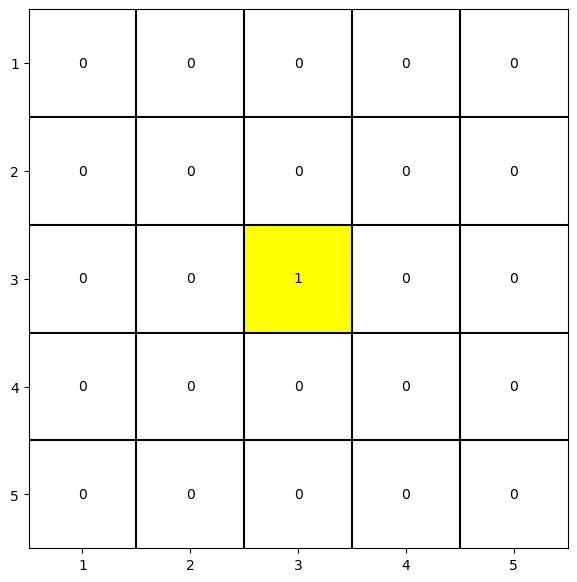

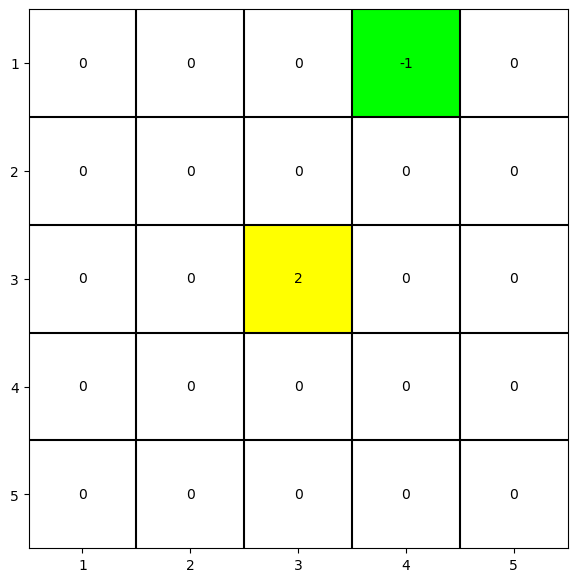

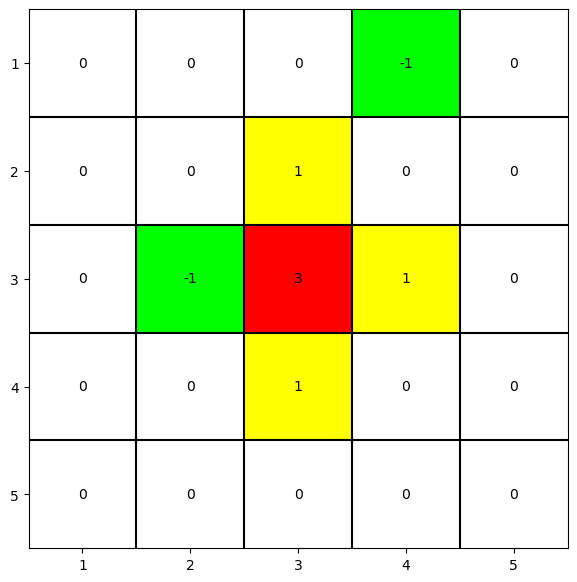

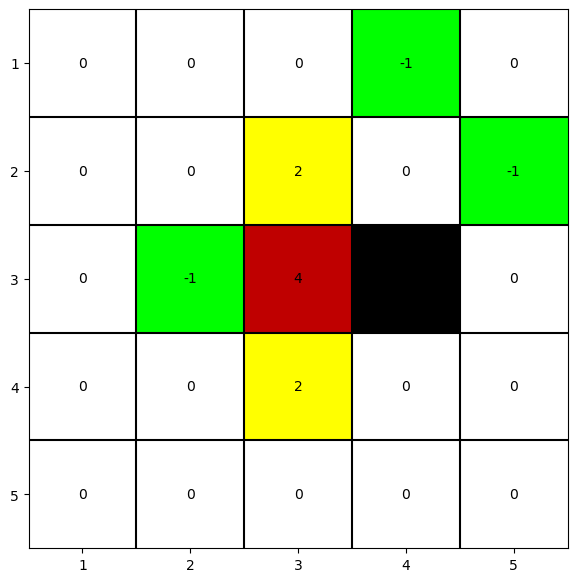

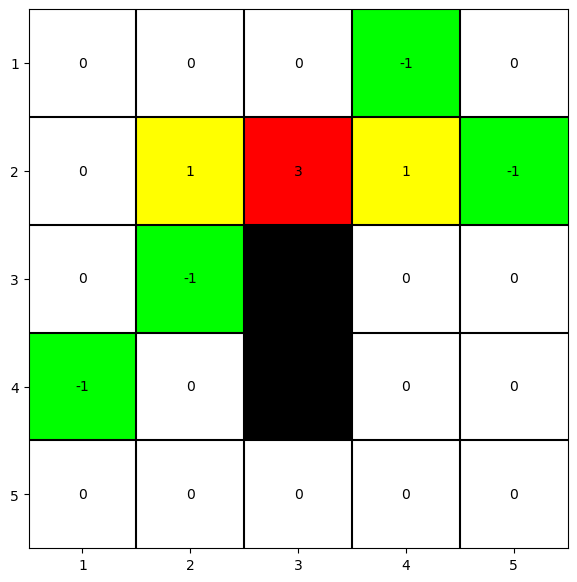

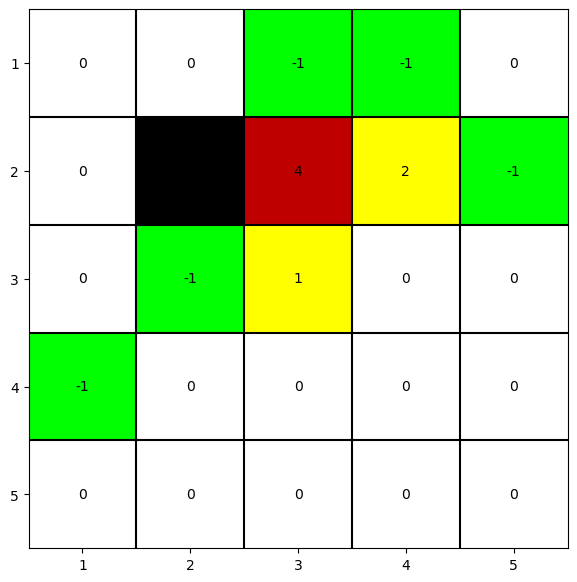

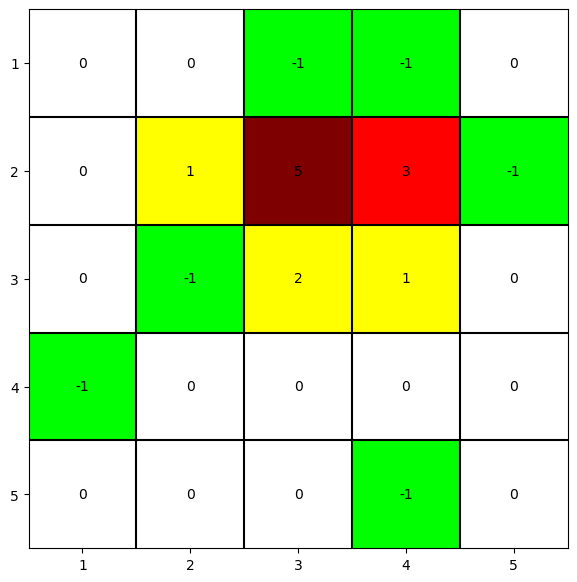

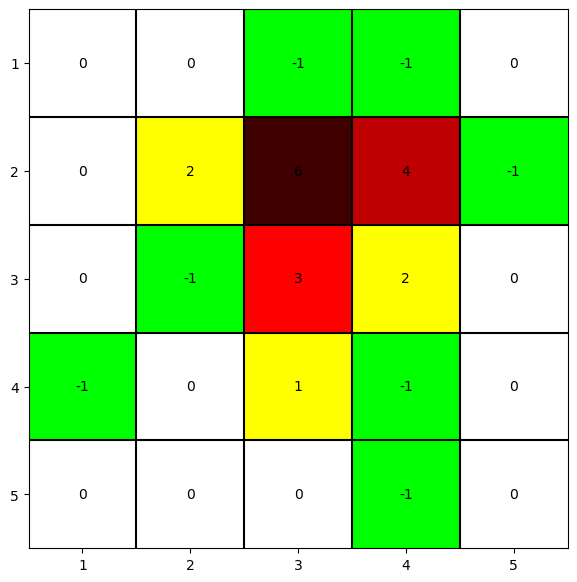

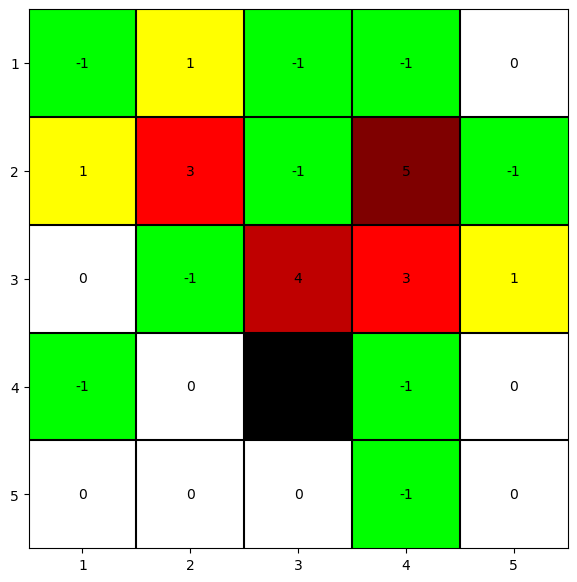

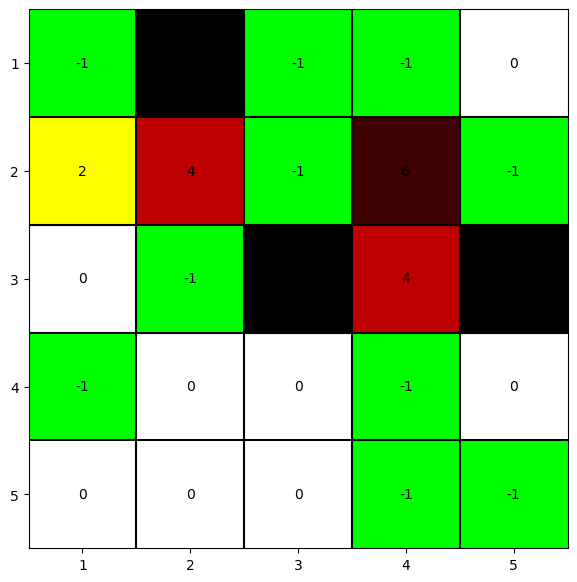

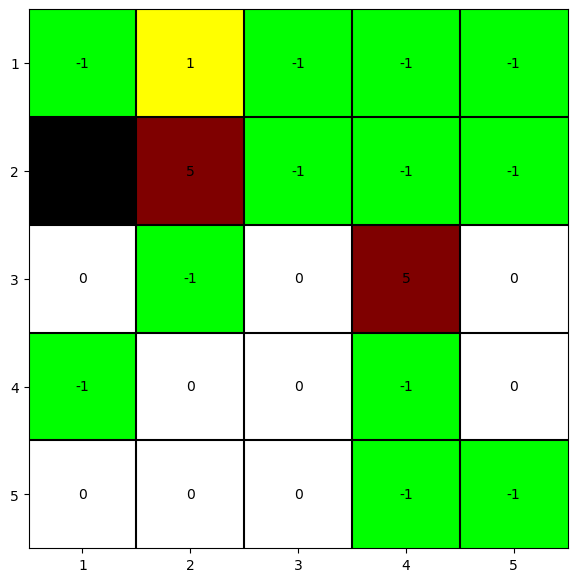

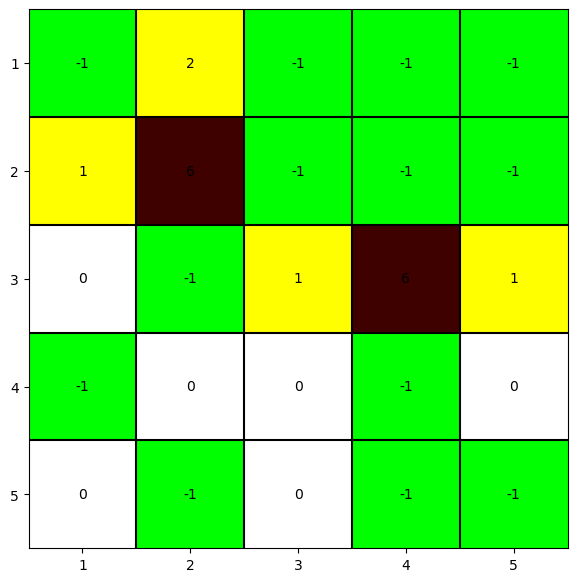

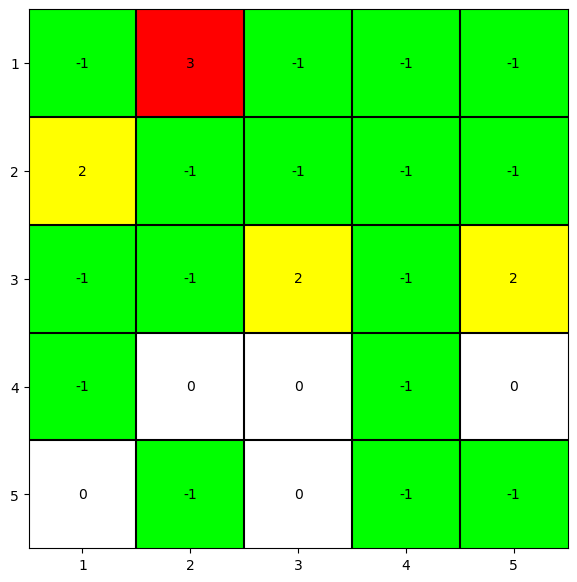

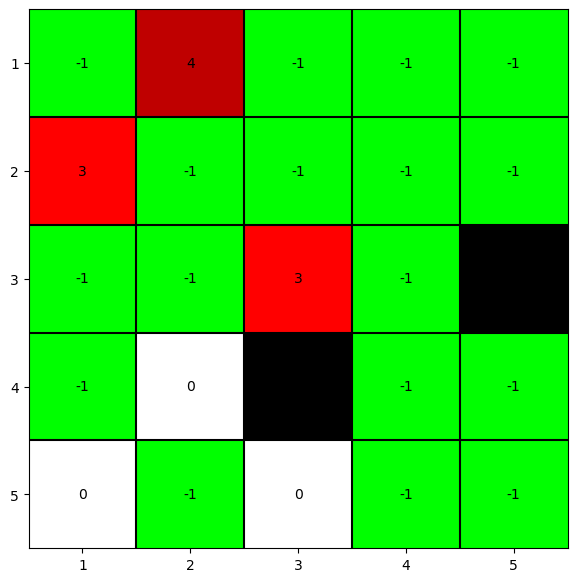

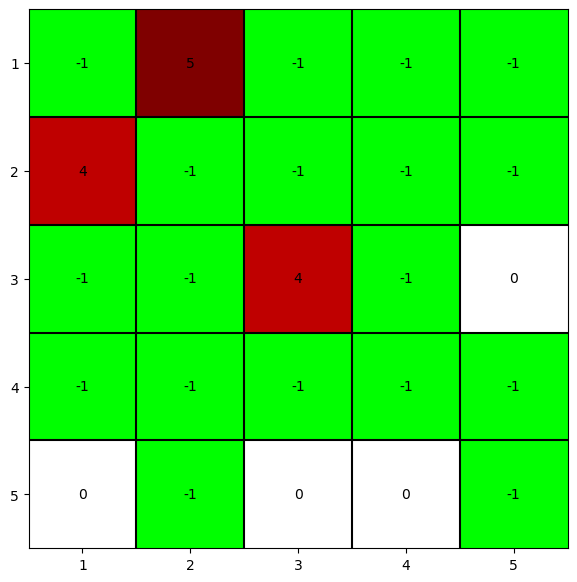

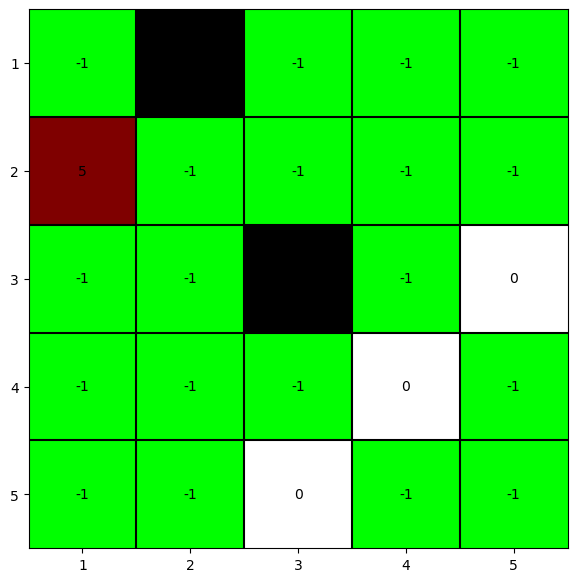

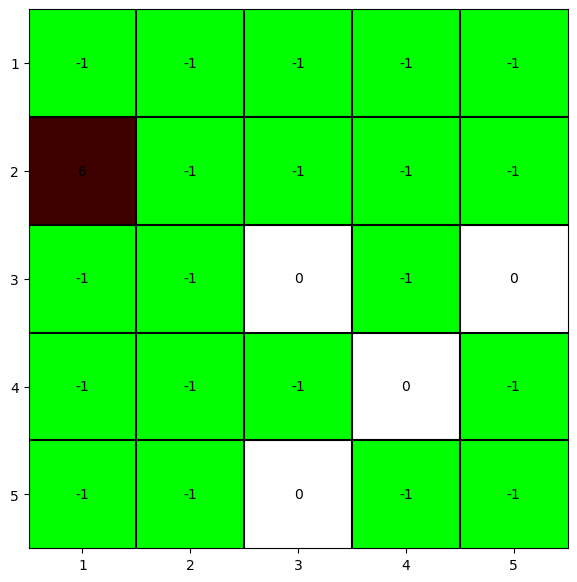

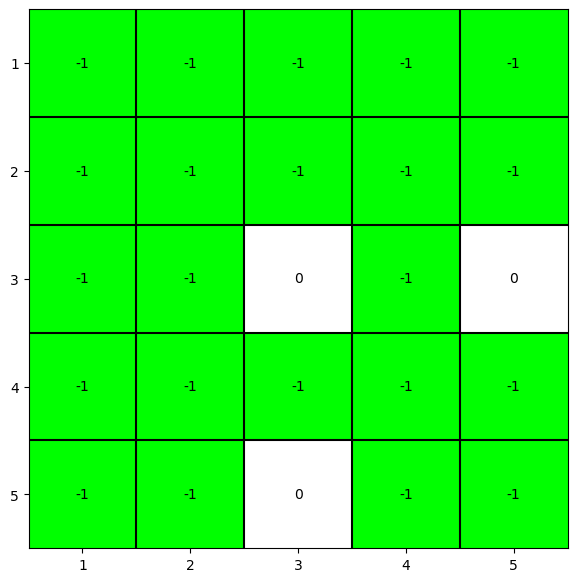

In [18]:
# Visualisierung als Bilderstrecke
if video_animation == 2:
    for index in range(1, len(plotarray)):
        update(index) # Jeder Plot zeigt den Schlafsaal am Ende des entsprechenden Tages.

#### 2.8.2 Visualisierung als Video

In [19]:
# Folgende Funktion werden benötigt, um das Video der Krankheitsausbreitung zu erstellen.
def arrayerstellen(f):
    global data_3d
    M = np.array(plotarray[f], copy=True)
    data_3d = np.ndarray(shape=(n, m, 3), dtype=int) # 3-dimensionaler Array mit gleichen Dimensionen wie der Schlafsaal, in dem die Farbwerte eingetragen werden # Quelle: [5] https://stackoverflow.com/questions/37719304/python-imshow-set-certain-value-to-defined-color
    for i in range(0, n):
        for j in range(0, m):
            data_3d[i][j] = color_map[M[i][j]] # Für jede Person wird der Farbwert entsprechend der Tabelle verändert.
    return data_3d
def zahlenzufugen(f):
    M = np.array(plotarray[f], copy=True)
    for i in range(0, n):
        for j in range(0, m):
            c = M[i, j]
            ax = plt.text(j, i, int(c), va='center', ha='center') # Zusätzlich zur Farbe wird auch der Zahlwert des aktuellen Gesundheitszustandes angegeben. # Quelle: [5] https://stackoverflow.com/questions/37719304/python-imshow-set-certain-value-to-defined-color
def update2(i):
    plt.clf()
    a = arrayerstellen(i+1)
    ax = plt.imshow(a)
    ax.set_array(a)
    zahlenzufugen(i+1)
    # Hinzufügen von Trennlinien in vertikaler und horizontaler Richtung
    # Quelle: [6] https://stackoverflow.com/questions/38973868/adjusting-gridlines-and-ticks-in-matplotlib-imshow
    ax = plt.hlines(y=np.arange(0, n-1)+0.5, xmin=-0.5, xmax=m-0.5, color="black")
    ax =  plt.vlines(x=np.arange(0, m-1)+0.5, ymin=-0.5, ymax=n-0.5, color="black")
    # Hinzufügen der Labels
    # Quelle: [7] https://stackoverflow.com/questions/10194482/custom-matplotlib-plot-chess-board-like-table-with-colored-cells
    ax = plt.xticks(range(m), labels = range(1, m+1))
    ax =  plt.yticks(range(n), labels = range(1, n+1))
    # Hinzufügen des Titels inkl. der Counter
    # Quelle: [8] https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.title.html
    ax = plt.title("Tag: " + str(i+1) + "\n" + "Anzahl der Infektionen: " + str(count_infektionen[i+1]) + "\n" + "Anzahl der Tode: " + str(count_tode[i+1]))

##### 2.8.2.1 Visualisierung als Video, ohne Speichern

In [23]:
# Visualisierung als Video, ohne Speichern
if video_animation == 1:
    fig, ax = plt.subplots(1,1)
    a = arrayerstellen(1)
    ax = plt.imshow(a)
    zahlenzufugen(1)
    # wie in der Vorlesung 
    line_ani = animation.FuncAnimation(fig, update2, frames=len(plotarray)-1, interval=500, repeat=False);
    html = HTML(line_ani.to_jshtml())
    display(html)
    plt.close() 

##### 2.8.2.2 Visualisierung als Video, mit Speichern

Die Animation wird im .mp4-Format gespeichert. Hierfür muss zunächst ffmpeg.exe installiert werden. Deutschsprachige Installationsanweisungen finden Sie in der beiligenden Datei ffmpeg_installation.pdf. Alternativ finden Sie unter den folgenden Links, entsprechend des Betriebssystems des genutzten Rechners, ein englischsprachiges YouTube-Tutorial zur Installation:
&nbsp;

[Windows](https://www.youtube.com/watch?v=IECI72XEox0)  
[MacOS](https://www.youtube.com/watch?v=H1o6MWnmwpY) 
&nbsp;

**Wichtig:** Die Datei ffmpeg.exe muss sich in dem Ordner befinden, in dem auch die Animation gespeichert werden soll.

In [24]:
# Visualisierung als Video, mit Speichern
# [9] https://holypython.com/how-to-save-matplotlib-animations-the-ultimate-guide/
# In der folgenden Zeile muss "/Users/Dominic/Documents/HTW Berlin/6. Semester/Mathematische Software/ffmpeg.exe" entsprechend des Speicherortes der Datei ffmpeg.exe auf Ihrem Rechner angepasst werden. Die Zeile kann nach erstmaligem Ausführen auskommentiert werden.
matplotlib.rcParams['animation.ffmpeg_path'] = r'/Users/Dominic/Documents/HTW Berlin/6. Semester/Mathematische Software/ffmpeg.exe'
if video_animation == 0:                       
    fig, ax = plt.subplots(1,1)
    a = arrayerstellen(1)
    ax = plt.imshow(a)
    zahlenzufugen(1)
    anim = animation.FuncAnimation(fig, update2, interval=500, frames = len(plotarray)-1)
    dateipfad= str(input("Bitte geben Sie den Dateipfad mit Dateiname und Dateiart am Ende an, z.B. /Users/Dominic/Documents/HTW Berlin/6. Semester/Mathematische Software/animation.mp4: "))
    f = r""+dateipfad
    anim.save(f, fps= 1) # Speichern des Videos
    plt.close() # Schließen des Plots

## 3. Interpretation der Ergebnisse

Sofern nicht anders angegeben, gelten in den Beispielen folgende Variablenwerte:  

 * $n=30$
 * $m=40$
 * $k$_$x=15$
 * $k$_$y=20$
 * $p=25$
 * $k=7$

Es sei zu beachten, dass der Code auf Zufallszahlen basiert. Die im Folgenden getroffenen Aussagen und Interpretationen der Ergebnisse gelten daher zwar für die statistische Mehrheit der Simulationen, können in Einzelfällen jedoch von den wahren Beobachtungen abweichen.

### 3.1 ohne Sonderfälle

Es ist zu beobachten, dass sich die Krankheit kreisförmig ausbreitet. Im Beispiel dauert die Epidemie 75 Tage (s. Anlage: ohneSonderfälle_Zentral.mp4).   

Je dezentraler Patient 0 im Schlafsaal platziert wird, desto länger ist die Dauer der Epidemie, da so die größtmögliche Distanz von Patient 0 zu einer der Schlafsaal-Wände maximiert wird. Um dies zu verdeutlichen sei $k$_$x=1$ und $k$_$y=1$. Die Epidemie dauert nun 121 Tage (s. Anlage: ohneSonderfälle_Rand.mp4).  

Die Ausbreitungsgeschwindigkeit hängt proportional von der Ansteckungswahrscheinlichkeit $p$ ab, d.h. eine hohe Ansteckungswahrscheinlichkeit $p$ hat eine hohe Ausbreitungsgeschwindigkeit zur Folge. Im Beispiel sei $p=0.75$, die Epidemie dauert nun nur noch 44 Tage (s. Anlage: ohneSonderfälle_hoheAnsteckungswahrscheinlichkeit.mp4). Analog für eine geringe Ansteckungswahrscheinlichkeit $p$.  

Des Weiteren hängt die Ausbreitung von der Krankheitsdauer $k$ ab. Je kürzer die Krankheitsdauer $k$, desto weniger Zeit verbleibt einer infizierten Person, ihre direkten Nachbarn anzustecken. Die Wahrscheinlichkeit, dass sich nicht alle Personen im Schlafsaal anstecken, ist daher hoch und die Epidemie dauert in der Regel kürzer. Im Beispiel sei $k=2$, die Epidemie dauert nun nur noch 4 Tage (s. Anlage: ohneSonderfälle_geringeKrankheitsdauer.mp4). Analog für eine hohe Krankheitsdauer $k$.   

Ist die Krankheitsdauer $k$ gering und die Ansteckungswahrscheinlichkeit $p$ gering, ist die Wahrscheinlichkeit, dass sich nicht alle Personen im Schlafsaal anstecken, sehr hoch. Die Epidemie dauert in Einzelfällen vergleichsweise lange, da sich die Krankheit nur schleppend ausbreitet, im Allgemeinen aber nur kurz, da die Krankheit vermutlich ausgerottet ist, bevor sie alle Personen im Schlafsaal erreicht hat.  
Ist jedoch die Krankheitsdauer $k$ hoch und die Ansteckungswahrscheinlichkeit $p$ hoch, ist die Wahrscheinlichkeit, dass sich nicht alle Personen im Schlafsaal anstecken, sehr gering. Die Epidemie dauert insgesamt kürzer, da sich die Krankheit schnell ausbreitet.

### 3.2 mit Sonderfall A

Die Implementierung einer Todeswahrscheinlichkeit $t$ wirkt sich je nach Wert der essenziellen Variablen auf unterschiedlichste Weise auf die Ausbreitung der Krankheit aus und lässt nur schwer allgemeine Einflusseffekte erkennen.  

Die Ausbreitungsgeschwindigkeit wird in der Regel leicht verringert, da verstorbene Personen nicht mehr ansteckend sind und durch gesunde (und daher zunächst nicht ansteckende), ansteckbare Personen ersetzt werden. Die Epidemie dauert also etwas länger, da immer wieder gesunde, ansteckbare Personen hinzukommen, welche sich zum Teil auch wieder anstecken. Dieser Effekt wird durch eine geringe Ansteckungswahrscheinlichkeit begünstigt. Im Beispiel gilt $t=0.05$, die Epidemie dauert 101 Tage und es sterben insgesamt 425 Personen (s. Anlage: mitSonderfallA.mp4).   

Der Einfluss einer Todeswahrscheinlichkeit $t$ auf die Ausbreitung der Krankheit hängt stark von der Höhe der bzw. der Relation zur Ansteckungswahrscheinlichkeit $p$ ab.  
Ist die Todeswahrscheinlichkeit $t$ hoch und die Ansteckungswahrscheinlichkeit $p$ gering, dauert die Epidemie im Regelfall vergleichsweise lange. Im Beispiel sei $t=0.25$ und $p=0.25$, die Epidemie dauert 148 Tage und es sterben insgesamt 1028 Personen (siehe Anlage: mitSonderfallA_hoheTodesundgeringeAnsteckungswahrscheinlichkeit.mp4). Bei geringer Krankeitsdauer $k$ und/ oder sehr geringer Ansteckungswahrscheinlichkeit $p$ kann es im Einzelnen dazu kommen, dass sich nicht alle Personen anstecken und die Krankheit wird vergleichsweise schnell ausgerottet sein.  
Sind jedoch sowohl die Ansteckungswahrscheinlichkeit $p$ als auch die Todeswahrscheinlichkeit $t$ hoch, führt dies zu einer vergleichsweise kurzen Epidemie. Die Personen im Schlafsaal stecken sich nach kurzer Zeit an, ein Großteil stirbt und wird durch neue, gesunde, aber ansteckbare Personen ersetzt. Durch die hohe Ansteckungswahrscheinlichkeit $p$ gibt es allerdings auch recht schnell eine Vielzahl an genesenen, immunen Personen, welche die neuen gesunden, aber ansteckbaren Personen umringen und von der Krankheit isolieren. Im Beispiel sei $t=0.25$ und $p=0.75$. Die Epidemie dauert zwar nur 96 Tage, allerdings sterben insgesamt 4637 Personen (siehe Anlage: mitSonderfallA_hoheTodesundhoheAnsteckungswahrscheinlichkeit.mp4).   

Darüber hinaus lässt die Implementierung der Todeswahrscheinlichkeit $t$ noch weitere Interpretationen zu. Verstorbene können als abreisende Personen interpretiert werden, die hinzukommenden gesunden, aber ansteckbare Personen sind Anreisende. Grund für die Abreise könnte bspw. ein schwerer Krankheitsverlauf mit Einlieferung ins Krankenhaus sein. Die Todeswahrscheinlichkeit $t$ kann in diesem Fall als Wahrscheinlichkeit eines schweren Krankheitsverlaufs verstanden werden.

### 3.3 mit Sonderfall B

Gehen wir davon aus, dass sich die gesamte Infektionszeit durch die Implementierung einer Inkubationszeit $i$ nicht erhöht, stecken sich in der Regel weniger Personen an, da Infizierte in der Inkubationszeit noch nicht ansteckend sind. Ihnen verbleibt schlichtweg weniger Zeit, in der sie andere anstecken können. Dieser Effekt wird durch eine geringe Ansteckungswahrscheinlichkeit $p$ verstärkt.  
In Einzelfällen dauert die Epidemie jedoch vergleichsweise länger, da der ansteckende Teil der Krankheitsdauer hinausgezögert wird (vgl. 3.1 zur Krankheitsdauer $k$). Dies ist insbesondere bei einer hohen Ansteckungswahrscheinlichkeit $p$ der Fall. Im Beispiel gilt $i=3$ und $k=4$, sodass die gesamte Infektionszeit weiterhin $7$ Tage beträgt. Es zeigt sich besagte schleppende Ausbreitung der Krankheit und die Epidemie dauert 149 Tage (s. Anlage: mitSonderfallB_i3_k4.mp4).

Kommt die Inkubationszeit $i$ zur normalen Krankheitsdauer $k$ hinzu, dauert die Epedemie länger, da die Ausbreitung der Krankheit lediglich hinausgezögert wird. Im Beispiel sei $i=3$ und $k=7$, die Dauer der Epidemie beträgt nun 151 Tage (siehe Anlage: mitSonderfallB_i3_k7.mp4).

### 3.4 mit Sonderfall C

Durch einen Impfstoff lässt sich in der Regel die Dauer der Epedemie verkürzen und die Zahl der infizierten Personen im Beobachtungszeitraum verringern, da die Anzahl der ansteckbaren Personen ab Tag $impf$_$start$ pro Tag zusätzlich um $impf$_$zahl$ sinkt. Durch die zufällige Auswahl der geimpften Personen kann es zudem passieren, dass gesunde, aber ansteckbare Personen von gesunden, nicht ansteckbaren Personen umringt werden und so von der Krankheit isoliert sind. Sie können sich ab diesem Zeitpunkt nicht mehr infizieren.  

Je früher der Impfstart, d.h. je kleiner der Wert der Variable $impf$_$start$, und je mehr Impfungen pro Tag, d.h. je größer der Wert der Variable $impf$_$zahl$, desto kürzer ist die Dauer der Epidemie. Es stecken sich in der Regel weniger Personen an, vor allem wenn viel geimpft wird. Im Beispiel sei $impf$_$start=30$, d.h. die Impfungen beginnen ca. einen Monat nach Ausbruch der Krankheit. Ist $impf$_$zahl=2$, dauert die Epidemie 73 Tage und es infizieren sich insgesamt 1122 Personen (s. Anlage: mitSonderfallC_2.mp4). Gilt $impf$_$zahl=10$, dauert die Epidemie 62 Tage und es infizieren sich insgesamt 880 Personen (s. Anlage: mitSonderfallC_10.mp4).  Falls $impf$_$zahl=20$, dauert die Epidemie 58 Tage und es infizieren sich insgesamt 687 Personen (s. Anlage: mitSonderfallC_20.mp4). 

### 3.5 mit Sonderfall D

Es ist zu beobachten, dass sich bei Implementierung eines nächtlichen Bettenwechsels einzelner, zufällig ausgewählter Personen anstelle nur eines Ausbreitungszentrums nun mehrere Ausbreitungszentren bilden. Dies geschieht, wenn eine infizierte Person das Bett wechselt. Die Epidemie dauert in der Regel kürzer, da es mehrere Ausbreitungszentren gibt, von denen aus sich die Krankheit kreisförmig ausbreitet, und sich somit täglich mehr Personen anstecken können. Im Beispiel ist $wechsel=5$. Die Epidemie dauert nur noch 67 Tage, verglichen zu den 75 Tagen ohne Sonderfälle (s. Anlage: mitSonderfallD_5).  
Je höher der Wert der Variable $wechsel$, desto höher die Ausbreitungsgeschwindigkeit aufgrund der starken Durchmischung der Personen im Schlafsaal infolge vieler Bettenwechsel. Im Beispiel sei nun $wechsel=15$, die Epidemie dauert nur 61 Tage (s. Anlage: mitSonderfallD_15).

In Einzelfällen stecken sich weniger Personen an, wenn ansteckbare Personen das Bett mit immunen Personen tauschen und sich nun umringt von immunen Personen befinden. Sie können sich ab diesem Zeitpunkt nicht mehr infizieren. Selbiges Phänomen ließ sich schon in 3.4 beobachten.   

Durch absichtliche Durchmischung ließe sich also unter der Voraussetzung, dass die Krankheit nicht tödlich ist, die Dauer der Epidemie verkürzen. Ein Praxisbeispiel mit ähnlichen Ansatz findet man bei der Bekämpfung der Windpocken. Bei sog. "Pocken-Parties" werden gesunde Kinder mit infizierten Kinden durchmischt, um so eine Ansteckung und nach in der Regel mildem Verlauf eine Immunisierung zu erzwingen.

### 3.6 mit Sonderfällen A, B, C, D

Kombiniert man nun die Sonderfälle, wirken alle Parameter zusammen und es sind vereinzelt die zuvor beschriebenen Wechselwirkungen zu beobachten. Es lassen sich jedoch keine allgemeingültigen Aussagen über die Ursache des Beobachteten mehr treffen (s. Anlage: mitallenSonderfällen.mp4).

## 4. Fazit
Es wurde die Ausbreitung einer ansteckenden Krankheit in einem Schlafsaal simuliert und durch die Implementierung von Sonderfällen (einer Impfung, Inkubationszeit und Todeswahrscheinlichkeit sowie einem Bettenwechsel von Personen) die jeweilige Einflussstärke dieser geprüft. Es lässt sich festhalten, dass alle der geprüften Parameter tatsächlich einen Einfluss auf die Dauer der Epidemie oder auch die Gesamtzahl der Infizierten besitzen. Hierbei ist zwischen proportionalen und antiproportionalen Wechselwirkungen zu unterscheiden.

Die Visualisierung ermöglicht eingängige Vergleiche unterschiedlicher Parameterwerte. 
Während eine Bilderstrecke sich sehr gut für die Betrachtung von Unterschieden zwischen den einzelnen Tagen eignet und im Regelfall in kürzerer Zeit verfügbar ist, kann man sich mithilfe des Videos effektiver einen Gesamteindruck über den Lebenszyklus der Krankheit verschaffen. Aufgrund dessen werden der Userin beide Optionen angeboten.

## 5. Literaturverzeichnis

Die Quellenangabe wurde entsprechend der Aufteilung der Arbeit von beiden für die jeweils bearbeiteten Abschnitte übernommen.

[1] *Python Random seed() Method*. https://www.w3schools.com/python/ref_random_seed.asp.  
[2] *How to reshape a Numpy array in Python?*. https://www.projectpro.io/recipes/reshape-numpy-array-in-python.  
[3] *numpy.random.choice*. https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html.  
[4] *Python | Check if all values in numpy are zero*. https://www.geeksforgeeks.org/python-check-if-all-values-in-numpy-are-zero/.  
[5] *python imshow, set certain value to defined color*. https://stackoverflow.com/questions/37719304/python-imshow-set-certain-value-to-defined-color.  
[6] *Adjusting gridlines and ticks in matplotlib imshow*. https://stackoverflow.com/questions/38973868/adjusting-gridlines-and-ticks-in-matplotlib-imshow.  
[7] *custom matplotlib plot : chess board like table with colored cells*. https://stackoverflow.com/questions/10194482/custom-matplotlib-plot-chess-board-like-table-with-colored-cells.  
[8] *matplotlib.pyplot.title*. https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.title.html.  
[9] *How to save Matplotlib Animations: The Ultimate Guide*. https://holypython.com/how-to-save-matplotlib-animations-the-ultimate-guide/.  
[10] *Download+Install FFMPEG on Windows 10 | Complete Guide 2022*. https://www.youtube.com/watch?v=IECI72XEox0.  
[11] *Installing FFmpeg on macOS Catalina (Updated Late 2020)*. https://www.youtube.com/watch?v=H1o6MWnmwpY.   
[12] *Markdown for Jupyter notebooks cheatsheet*. https://www.ibm.com/docs/en/watson-studio-local/1.2.3?topic=notebooks-markdown-jupyter-cheatsheet.

Darüber hinaus wurden die Inhalte der Vorlesung 'Mathematische Software' sowie die Dokumentationen der folgenden Pakete genutzt:
&nbsp;

 * [Matplotlib](https://matplotlib.org/)
 * [NumPy](https://numpy.org/)